In [38]:
! pip install kaggle
! pip install transformers

/bin/bash: -c: line 0: syntax error near unexpected token `'punkt''
/bin/bash: -c: line 0: `nltk.download('punkt')'


In [2]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [3]:
! mkdir dataset
% cd /content/dataset/

/content/dataset


In [4]:
! kaggle datasets download -d datafiniti/consumer-reviews-of-amazon-products
! unzip consumer-reviews-of-amazon-products.zip

  0% 0.00/16.3M [00:00<?, ?B/s]
100% 16.3M/16.3M [00:00<00:00, 148MB/s]
Archive:  consumer-reviews-of-amazon-products.zip
  inflating: 1429_1.csv              
  inflating: Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products.csv  
  inflating: Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products_May19.csv  


In [49]:
import numpy as np 
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns

import re
import string

import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
from nltk.corpus import wordnet
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer

import spacy
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

from collections import Counter

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.utils import shuffle
from sklearn.naive_bayes import MultinomialNB

from xgboost import XGBClassifier

from transformers import pipeline

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [8]:
df = pd.read_csv('/content/dataset/1429_1.csv')
df.head()

,id,name,asins,brand,categories,keys,manufacturer,reviews.date,reviews.dateAdded,reviews.dateSeen,reviews.didPurchase,reviews.doRecommend,reviews.id,reviews.numHelpful,reviews.rating,reviews.sourceURLs,reviews.text,reviews.title,reviews.userCity,reviews.userProvince,reviews.username
0,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",B01AHB9CN2,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...","841667104676,amazon/53004484,amazon/b01ahb9cn2...",Amazon,2017-01-13T00:00:00.000Z,2017-07-03T23:33:15Z,"2017-06-07T09:04:00.000Z,2017-04-30T00:45:00.000Z",NaN,True,NaN,0.0,5.0,http://reviews.bestbuy.com/3545/5620406/review...,This product so far has not disappointed. My c...,Kindle,NaN,NaN,Adapter
1,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",B01AHB9CN2,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...","841667104676,amazon/53004484,amazon/b01ahb9cn2...",Amazon,2017-01-13T00:00:00.000Z,2017-07-03T23:33:15Z,"2017-06-07T09:04:00.000Z,2017-04-30T00:45:00.000Z",NaN,True,NaN,0.0,5.0,http://reviews.bestbuy.com/3545/5620406/review...,great for beginner or experienced person. Boug...,very fast,NaN,NaN,truman
2,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",B01AHB9CN2,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...","841667104676,amazon/53004484,amazon/b01ahb9cn2...",Amazon,2017-01-13T00:00:00.000Z,2017-07-03T23:33:15Z,"2017-06-07T09:04:00.000Z,2017-04-30T00:45:00.000Z",NaN,True,NaN,0.0,5.0,http://reviews.bestbuy.com/3545/5620406/review...,Inexpensive tablet for him to use and learn on...,Beginner tablet for our 9 year old son.,NaN,NaN,DaveZ
3,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",B01AHB9CN2,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...","841667104676,amazon/53004484,amazon/b01ahb9cn2...",Amazon,2017-01-13T00:00:00.000Z,2017-07-03T23:33:15Z,"2017-06-07T09:04:00.000Z,2017-04-30T00:45:00.000Z",NaN,True,NaN,0.0,4.0,http://reviews.bestbuy.com/3545/5620406/review...,I've had my Fire HD 8 two weeks now and I love...,Good!!!,NaN,NaN,Shacks
4,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",B01AHB9CN2,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...","841667104676,amazon/53004484,amazon/b01ahb9cn2...",Amazon,2017-01-12T00:00:00.000Z,2017-07-03T23:33:15Z,"2017-06-07T09:04:00.000Z,2017-04-30T00:45:00.000Z",NaN,True,NaN,0.0,5.0,http://reviews.bestbuy.com/3545/5620406/review...,I bought this for my grand daughter when she c...,Fantastic Tablet for kids,NaN,NaN,explore42


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34660 entries, 0 to 34659
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    34660 non-null  object 
 1   name                  27900 non-null  object 
 2   asins                 34658 non-null  object 
 3   brand                 34660 non-null  object 
 4   categories            34660 non-null  object 
 5   keys                  34660 non-null  object 
 6   manufacturer          34660 non-null  object 
 7   reviews.date          34621 non-null  object 
 8   reviews.dateAdded     24039 non-null  object 
 9   reviews.dateSeen      34660 non-null  object 
 10  reviews.didPurchase   1 non-null      object 
 11  reviews.doRecommend   34066 non-null  object 
 12  reviews.id            1 non-null      float64
 13  reviews.numHelpful    34131 non-null  float64
 14  reviews.rating        34627 non-null  float64
 15  reviews.sourceURLs 

In [10]:
data = df[["reviews.text","reviews.rating"]]
data.head()

,reviews.text,reviews.rating
0,This product so far has not disappointed. My c...,5.0
1,great for beginner or experienced person. Boug...,5.0
2,Inexpensive tablet for him to use and learn on...,5.0
3,I've had my Fire HD 8 two weeks now and I love...,4.0
4,I bought this for my grand daughter when she c...,5.0


In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34660 entries, 0 to 34659
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   reviews.text    34659 non-null  object 
 1   reviews.rating  34627 non-null  float64
dtypes: float64(1), object(1)
memory usage: 541.7+ KB


In [12]:
data.dropna(inplace=True)
data.isnull().sum()

reviews.text      0
reviews.rating    0
dtype: int64

In [13]:
import random

n_samples = 5

for _ in range(n_samples):
    i = random.choice(range(data.shape[0]))
    print(f"REVIEW TEXT:\n{data['reviews.text'][i]} \n\nRATE:\n{data['reviews.rating'][i]}")
    print('\n', 90*"-", '\n')

REVIEW TEXT:
Purchased during Black Friday sale 2016 as an impulse buy. Great little tablet and great value! 

RATE:
4.0

 ------------------------------------------------------------------------------------------ 

REVIEW TEXT:
A great Kindle reader. Easy to order, read and store books. Also speedy for finding Amazon products and ordering them. But the other apps are really slow - too slow. 

RATE:
4.0

 ------------------------------------------------------------------------------------------ 

REVIEW TEXT:
Gave this to my daughter for Christmas. She loves it. Uses it every day. Good buy! 

RATE:
5.0

 ------------------------------------------------------------------------------------------ 

REVIEW TEXT:
You can go cheap for the regular kindle, but in my opinion its worth the extra money to get the paperwhite model. If you had both beside each other or sometimes read at night, you'd go with the paperwhite too. 

RATE:
5.0

 ----------------------------------------------------------

In [14]:
data.describe()

,reviews.rating
count,34626.000000
mean,4.584561
std,0.735660
min,1.000000
25%,4.000000
50%,5.000000
75%,5.000000
max,5.000000


In [15]:
data['reviews.rating'].value_counts().sort_index(ascending=False)

5.0    23774
4.0     8541
3.0     1499
2.0      402
1.0      410
Name: reviews.rating, dtype: int64

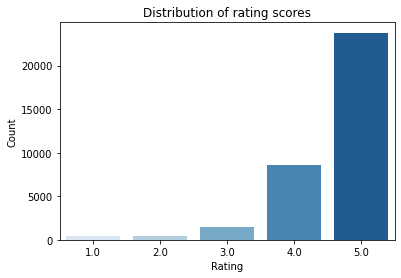

In [16]:
sns.countplot(data['reviews.rating'], palette='Blues')

plt.title('Distribution of rating scores')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

In [17]:
# load the other data
data2 = pd.read_csv("/content/dataset/Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products_May19.csv")
data2 = data2[['reviews.text', 'reviews.rating']]
# use only data of rating lower than or equal to 3
data2 = data2[data2["reviews.rating"] <= 3].reset_index(drop=True) # reset index after filtering rows

data3 = pd.read_csv("/content/dataset/Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products.csv")
data3 = data3[['reviews.text', 'reviews.rating']]
# use only data of rating lower than or equal to 3
data3 = data3[data3["reviews.rating"] <= 3].reset_index(drop=True) # reset index after filtering rows

In [18]:
# distribution of rating
data2['reviews.rating'].value_counts().sort_index(ascending=False)

3    1206
2     616
1     965
Name: reviews.rating, dtype: int64

In [19]:
# distribution of rating
data3['reviews.rating'].value_counts().sort_index(ascending=False)

3    197
2     54
1     63
Name: reviews.rating, dtype: int64

In [20]:
# concatenation
data = pd.concat([data, data2, data3])

# assert data.shape[0] == data.shape[0] + data2.shape[0] + data3.shape[0]
data.head()

,reviews.text,reviews.rating
0,This product so far has not disappointed. My c...,5.0
1,great for beginner or experienced person. Boug...,5.0
2,Inexpensive tablet for him to use and learn on...,5.0
3,I've had my Fire HD 8 two weeks now and I love...,4.0
4,I bought this for my grand daughter when she c...,5.0


In [21]:
# distribution of rating
data['reviews.rating'].value_counts().sort_index(ascending=False)

5.0    23774
4.0     8541
3.0     2902
2.0     1072
1.0     1438
Name: reviews.rating, dtype: int64

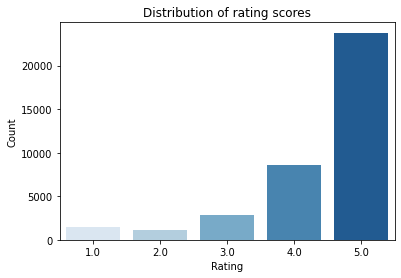

In [22]:
# distribution of rating
sns.countplot(data['reviews.rating'], palette='Blues')

plt.title('Distribution of rating scores')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

In [23]:
# map ratings 1, 2, 3 to 0 (NEGATIVE) and 4, 5 to 1 (POSITIVE) 
sentiment_score = {1: 0,
                   2: 0,
                   3: 0,
                   4: 1,
                   5: 1}

sentiment = {0: 'NEGATIVE',
             1: 'POSITIVE'}


# mapping
data['sentiment_score'] = data['reviews.rating'].map(sentiment_score)
data['sentiment'] = data['sentiment_score'].map(sentiment)

data.head()

,reviews.text,reviews.rating,sentiment_score,sentiment
0,This product so far has not disappointed. My c...,5.0,1,POSITIVE
1,great for beginner or experienced person. Boug...,5.0,1,POSITIVE
2,Inexpensive tablet for him to use and learn on...,5.0,1,POSITIVE
3,I've had my Fire HD 8 two weeks now and I love...,4.0,1,POSITIVE
4,I bought this for my grand daughter when she c...,5.0,1,POSITIVE


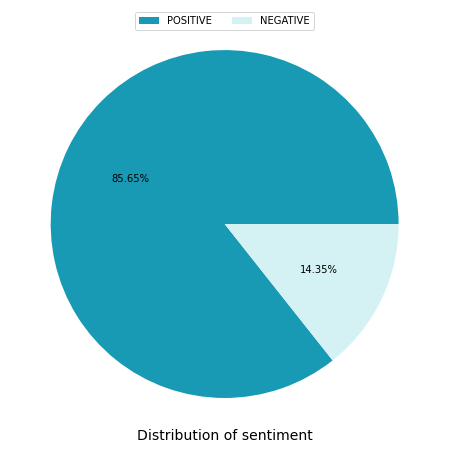

In [24]:
# distribution of sentiment
plt.figure(figsize = (8, 8))

labels = ['POSITIVE', 'NEGATIVE']
colors = ['#189AB4', '#D4F1F4']
plt.pie(data['sentiment'].value_counts(), autopct='%0.2f%%',colors=colors)

plt.title('Distribution of sentiment', size=14, y=-0.01)
plt.legend(labels, ncol=2, loc=9)
plt.show()

In [25]:
# get all used words 
all_words = pd.Series(' '.join(data['reviews.text']).split())

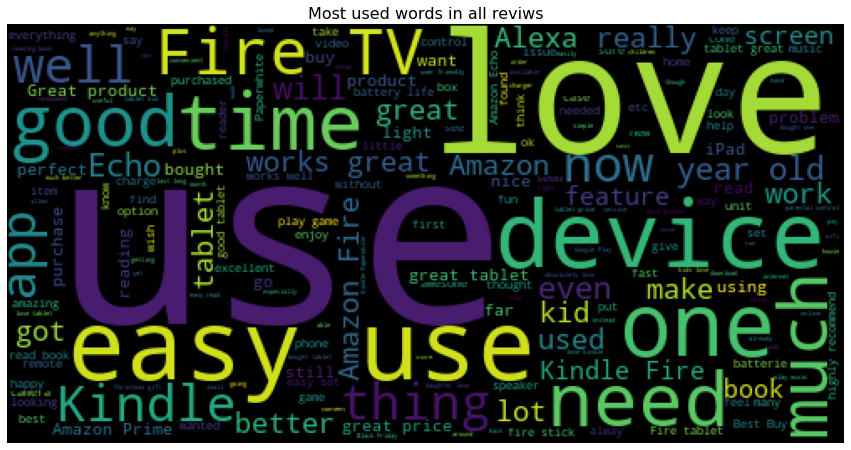

In [27]:
# plot word cloud
wordcloud = WordCloud(width = 500, height = 250).generate(' '.join(all_words))

plt.figure(figsize=(15,8))

plt.imshow(wordcloud)
plt.title("Most used words in all reviws", size=16)

plt.axis("off")
plt.show()

In [28]:
# get words used positive reivews 
positiveWords = pd.Series(' '.join(data[data['sentiment']=='POSITIVE']['reviews.text']).split())

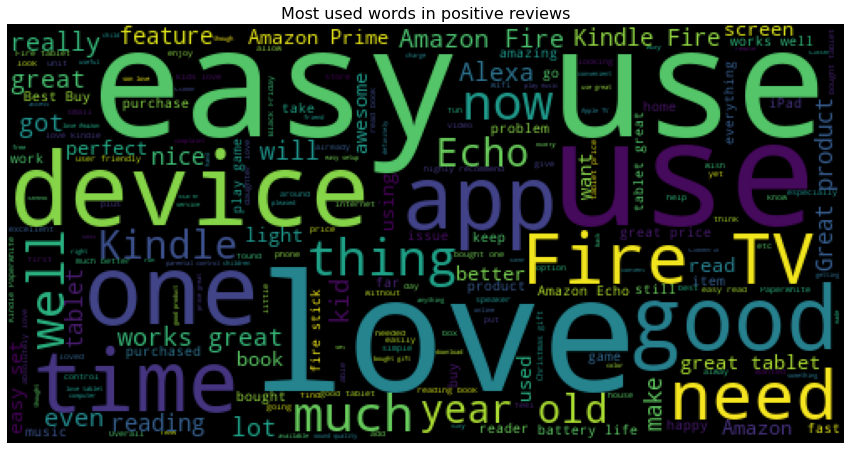

In [29]:
# plot word cloud
wordcloud = WordCloud(width = 500, height = 250).generate(' '.join(positiveWords))

plt.figure(figsize=(15,8))

plt.imshow(wordcloud)
plt.title("Most used words in positive reviews", size=16)

plt.axis("off")
plt.show()

In [30]:
# get words used negative reivews 
negativeWords = pd.Series(' '.join(data[data['sentiment']=='NEGATIVE']['reviews.text']).split())

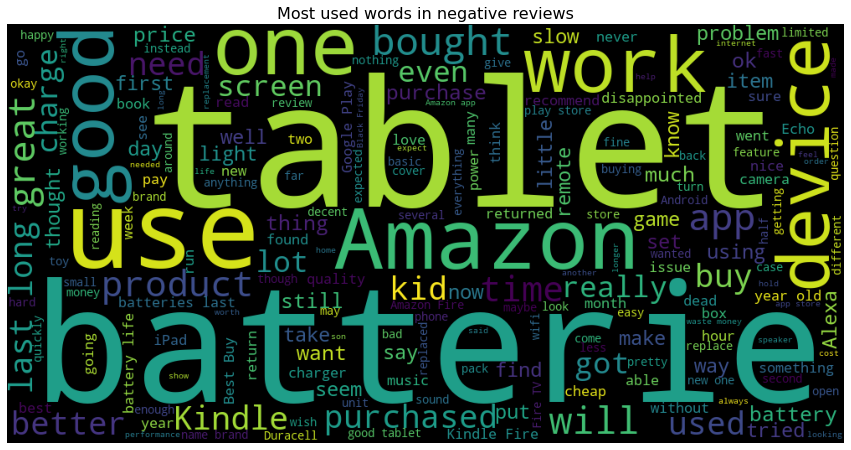

In [31]:
# plot word cloud
wordcloud = WordCloud(width = 1000, height = 500).generate(' '.join(negativeWords))

plt.figure(figsize=(15,8))

plt.imshow(wordcloud)
plt.title("Most used words in negative reviews", size=16)

plt.axis("off")
plt.show()

In [32]:
def clean_text(text:str):
    """ Return cleaned text:
            - lowercase
            - remove whitespaces
            - remove HTML tags
            - replace digit with spaces
            - replace punctuations with spaces
            - remove extra spaces and tabs
        ------
        input: text (str)    
        output: cleaned text (str)
    """
    text = str(text)
    
    text = text.lower()
    text = text.strip()
    
    text = re.sub(' \d+', ' ', text)
    text = re.compile('<.*?>').sub('', text)
    text = re.compile('[%s]' % re.escape(string.punctuation)).sub(' ', text)
    text = re.sub('\s+', ' ', text)
    
    text = text.strip()
    
    return text

In [33]:
# test
text = "   This is a message to be cleaned. It may involve some things like: <br>, ?, :, ''  26 adjacent spaces and tabs     .  "
print(text, '\n')
clean_text(text)

   This is a message to be cleaned. It may involve some things like: <br>, ?, :, ''  26 adjacent spaces and tabs     .   



'this is a message to be cleaned it may involve some things like adjacent spaces and tabs'

In [37]:
def remove_stopwords(text:str):
    """ Remove stopwords from text:
        ------
        input: text (str)    
        output: cleaned text (str)
    """
    text = str(text)
    filtered_sentence = []

    # Stop word lists can be adjusted for your problem
    stop_words = ["a", "an", "the", "this", "that", "is", "it", "to", "and"]

    # Tokenize the sentence
    words = word_tokenize(text)
    for w in words:
        if w not in stop_words:
            filtered_sentence.append(w)
    text = " ".join(filtered_sentence)
    
    return text

In [40]:
# test
text = "   This is a message to be cleaned. It may involve some things like: <br>, ?, :, ''  26 adjacent spaces and tabs     .  "
print(text, '\n')
text = clean_text(text)
remove_stopwords(text)

   This is a message to be cleaned. It may involve some things like: <br>, ?, :, ''  26 adjacent spaces and tabs     .   



'message be cleaned may involve some things like adjacent spaces tabs'

In [41]:
def stemm_text(text:str):
    """ Stemm text:
    ------
    input: text (str)    
    output: Stemmed text (str)
    """
    text = str(text)
    # Initialize the stemmer
    snow = SnowballStemmer('english')

    stemmed_sentence = []
    # Tokenize the sentence
    words = word_tokenize(text)
    for w in words:
        # Stem the word/token
        stemmed_sentence.append(snow.stem(w))
    text = " ".join(stemmed_sentence)
    
    return text


In [42]:
# test
text = "   This is a message to be cleaned. It may involve some things like: <br>, ?, :, ''  26 adjacent spaces and tabs     .  "
print(text, '\n')
text = clean_text(text)
text = remove_stopwords(text)
stemm_text(text)

   This is a message to be cleaned. It may involve some things like: <br>, ?, :, ''  26 adjacent spaces and tabs     .   



'messag be clean may involv some thing like adjac space tab'

In [43]:
# This is a helper function to map NTLK position tags
# Full list is available here: https://www.ling.upenn.edu/courses/Fall_2003/ling001/penn_treebank_pos.html
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [44]:
def lemmatize(text:str):
    """ lemmatize text:
    ------
    input: text (str)    
    output: lemmatized text (str)
    """
    text = str(text)
    
    # Initialize the lemmatizer
    wl = WordNetLemmatizer()

    lemmatized_sentence = []

    # Tokenize the sentence
    words = word_tokenize(text)
    # Get position tags
    word_pos_tags = nltk.pos_tag(words)
    # Map the position tag and lemmatize the word/token
    for idx, tag in enumerate(word_pos_tags):
        lemmatized_sentence.append(wl.lemmatize(tag[0], get_wordnet_pos(tag[1])))

    lemmatized_text = " ".join(lemmatized_sentence)
    
    return lemmatized_text


In [50]:
# test
text = "   This is a message to be cleaned. It may involve some things like: <br>, ?, :, ''  26 adjacent spaces and tabs     .  "
print(text, '\n')
text = clean_text(text)
text = remove_stopwords(text)
# text = stemm_text(text)
lemmatize(text)

   This is a message to be cleaned. It may involve some things like: <br>, ?, :, ''  26 adjacent spaces and tabs     .   



'message be clean may involve some thing like adjacent space tabs'

In [51]:
# clean text
data['text'] = data['reviews.text'].apply(clean_text)
# remove stopwords
data['text'] = data['text'].apply(remove_stopwords)
# lemmatize
data['text'] = data['text'].apply(lemmatize)

In [52]:
# check some processed reviews
import random

i = random.choice(range(len(data)))

print(f"Original review: \n{data['reviews.text'].iloc[i]}\n")
print(f"Processed review: \n{data['text'].iloc[i]}") 

Original review: 
This is great for kids and adult. A great product for gaming reading and more..

Processed review: 
great for kid adult great product for game reading more


In [53]:
# export cleaned data to csv
data.to_csv('cleaned_data.csv', index=False)

In [54]:
data = pd.read_csv('cleaned_data.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37727 entries, 0 to 37726
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   reviews.text     37727 non-null  object 
 1   reviews.rating   37727 non-null  float64
 2   sentiment_score  37727 non-null  int64  
 3   sentiment        37727 non-null  object 
 4   text             37726 non-null  object 
dtypes: float64(1), int64(1), object(3)
memory usage: 1.4+ MB


In [55]:
data[data['text'].isnull()]

,reviews.text,reviews.rating,sentiment_score,sentiment,text
9681,.................................................,5.0,1,POSITIVE,NaN


In [56]:
data.dropna(inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37726 entries, 0 to 37726
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   reviews.text     37726 non-null  object 
 1   reviews.rating   37726 non-null  float64
 2   sentiment_score  37726 non-null  int64  
 3   sentiment        37726 non-null  object 
 4   text             37726 non-null  object 
dtypes: float64(1), int64(1), object(3)
memory usage: 1.7+ MB


In [57]:
vectorizer = TfidfVectorizer(max_features=700)
vectorizer.fit(data['text'])
features = vectorizer.transform(data['text'])

features.toarray()

array([[0.        , 0.31997416, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [58]:
tf_idf = pd.DataFrame(features.toarray(), columns=vectorizer.get_feature_names())
# tf_idf.drop('50', axis=1, inplace=True)
tf_idf.head()

,50,ability,able,about,absolutely,access,account,actually,ad,add,addition,additional,adjust,adult,affordable,after,again,age,ago,alarm,alexa,all,allow,almost,along,already,also,although,always,amaze,amazing,amazon,amount,android,annoy,another,answer,any,anyone,anything,...,way,we,weather,web,week,weight,well,what,when,where,which,while,white,who,whole,why,wife,wifi,will,win,wireless,wish,with,within,without,wonderful,word,work,worry,worth,would,wouldn,wrong,year,yet,you,young,your,youtube,yr
0,0.0,0.319974,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.00000,0.0,0.000000,0.214298,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.142770,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
1,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.00000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
2,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.305099,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.00000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.146087,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
3,0.0,0.000000,0.114228,0.0,0.0,0.129196,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.083885,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.149379,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.094053,0.0,0.0,0.13296,0.0,0.088685,0.000000,0.000000,0.146387,0.114165,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.075228,0.0,0.0,0.0,0.0
4,0.0,0.000000,0.000000,0.0,0.0,0.117444,0.0,0.0,0.0,0.0,0.0,0.153771,0.0,0.0,0.0,0.0,0.0,0.26816,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.090992,0.0,0.0,0.0,0.000000,0.070193,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.00000,0.0,0.000000,0.000000,0.177061,0.000000,0.103780,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.092072,0.0,0.0,0.0,0.059375,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.068385,0.0,0.0,0.0,0.0


In [59]:
X_train, X_test, y_train, y_test = train_test_split(tf_idf, data['sentiment_score'], test_size=0.2, random_state=42)

print (f'Train set shape\t:{X_train.shape}\nTest set shape\t:{X_test.shape}')

Train set shape	:(30180, 700)
Test set shape	:(7546, 700)


In [60]:
yy = pd.DataFrame(y_train)
train_data = pd.concat([X_train, yy],axis=1)
train_data.head()

,50,ability,able,about,absolutely,access,account,actually,ad,add,addition,additional,adjust,adult,affordable,after,again,age,ago,alarm,alexa,all,allow,almost,along,already,also,although,always,amaze,amazing,amazon,amount,android,annoy,another,answer,any,anyone,anything,...,we,weather,web,week,weight,well,what,when,where,which,while,white,who,whole,why,wife,wifi,will,win,wireless,wish,with,within,without,wonderful,word,work,worry,worth,would,wouldn,wrong,year,yet,you,young,your,youtube,yr,sentiment_score
0,0.0,0.319974,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.00000,0.0,0.000000,0.214298,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.142770,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.00000,0.0,0.000000,0.0,0.0,0.0,0.0,1.0
1,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.00000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.00000,0.0,0.000000,0.0,0.0,0.0,0.0,1.0
2,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.305099,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.00000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.146087,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.00000,0.0,0.000000,0.0,0.0,0.0,0.0,1.0
3,0.0,0.000000,0.114228,0.0,0.0,0.129196,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.083885,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.149379,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.094053,0.0,0.0,0.13296,0.0,0.088685,0.000000,0.0,0.146387,0.114165,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.00000,0.0,0.075228,0.0,0.0,0.0,0.0,1.0
5,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.267001,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.131786,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.00000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.152448,0.0,0.0,0.16796,0.0,0.000000,0.0,0.0,0.0,0.0,1.0


In [61]:
train_data['sentiment_score'].value_counts()

1.0    25902
0.0     4278
Name: sentiment_score, dtype: int64

In [62]:
target_count = train_data['sentiment_score'].value_counts()
negative_class = train_data[train_data['sentiment_score'] == 0]
positive_class = train_data[train_data['sentiment_score'] == 1]

negative_over = negative_class.sample(target_count[1], replace=True)

df_train_over = pd.concat([positive_class, negative_over], axis=0)
df_train_over = shuffle(df_train_over)
df_train_over.head()

,50,ability,able,about,absolutely,access,account,actually,ad,add,addition,additional,adjust,adult,affordable,after,again,age,ago,alarm,alexa,all,allow,almost,along,already,also,although,always,amaze,amazing,amazon,amount,android,annoy,another,answer,any,anyone,anything,...,we,weather,web,week,weight,well,what,when,where,which,while,white,who,whole,why,wife,wifi,will,win,wireless,wish,with,within,without,wonderful,word,work,worry,worth,would,wouldn,wrong,year,yet,you,young,your,youtube,yr,sentiment_score
11148,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
13344,0.0,0.0,0.269001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
35526,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
36060,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6691,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [64]:
df_train_over.dropna(inplace=True)

In [67]:
df_train_over['sentiment_score'].value_counts()

1.0    22189
0.0    21274
Name: sentiment_score, dtype: int64

In [68]:
X_train = df_train_over.iloc[:,:-1]
y_train = df_train_over['sentiment_score']

In [70]:
def modeling(Model, Xtrain = X_train, Xtest = X_test):
    """
    This function apply countVectorizer with machine learning algorithms. 
    """
    
    # Instantiate the classifier: model
    model = Model
    
    # Fitting classifier to the Training set (all features)
    model.fit(Xtrain, y_train)
    
    global y_pred
    # Predicting the Test set results
    y_pred = model.predict(Xtest)
    
    # Assign f1 score to a variable
    print(classification_report(y_test, y_pred))
    print ('AUC ',roc_auc_score(y_test, y_pred))
    #cm = confusion_matrix(y_test, y_pred)
    confusion_matrix = pd.crosstab(index=y_test, columns=np.round(y_pred), rownames=['Actual'], colnames=['Predictions']).astype(int)
    plt.figure(figsize = (8,8))

    '''
    cmapGR = LinearSegmentedColormap.from_list(
        name='test', 
        colors=['red','green']
    )
    '''
    sns.heatmap(confusion_matrix, annot=True,annot_kws={"fontsize":12}, fmt='.2f', cmap='Blues').set_title('Confusion Matrix')

              precision    recall  f1-score   support

           0       0.45      0.77      0.57      1134
           1       0.95      0.83      0.89      6412

    accuracy                           0.83      7546
   macro avg       0.70      0.80      0.73      7546
weighted avg       0.88      0.83      0.84      7546

AUC  0.8042337669339126


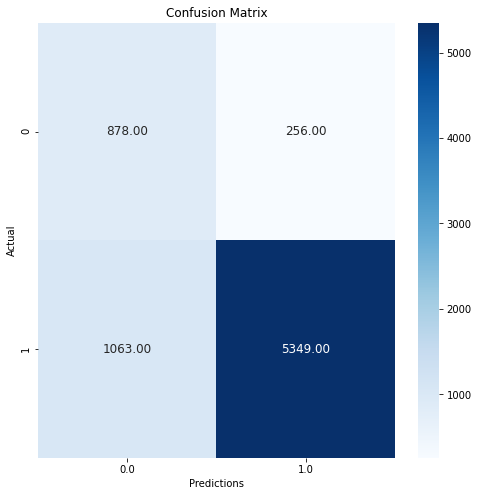

In [71]:
modeling(MultinomialNB())

              precision    recall  f1-score   support

           0       0.53      0.72      0.61      1134
           1       0.95      0.89      0.92      6412

    accuracy                           0.86      7546
   macro avg       0.74      0.80      0.76      7546
weighted avg       0.88      0.86      0.87      7546

AUC  0.8030977796261639


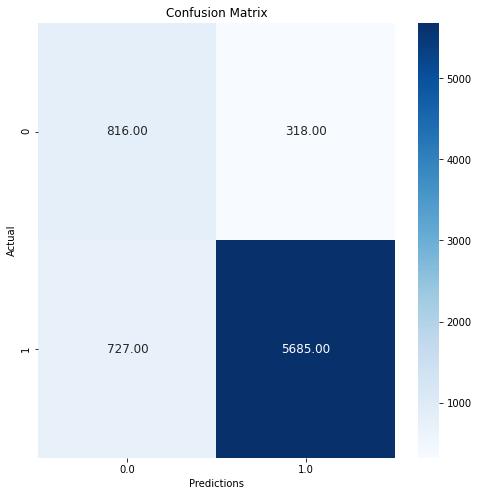

In [72]:
modeling(XGBClassifier());

In [73]:
# Build sentiment analysis pipeline
sentiment_analyzer = pipeline('sentiment-analysis')

In [74]:
# test
sentiment_analyzer(['Good product', 'Bad custemer service'])

[{'label': 'POSITIVE', 'score': 0.9998588562011719},
 {'label': 'NEGATIVE', 'score': 0.9997892379760742}]

In [75]:
def transformer_check(n=1000):
    """ Return Dataframe of reviews sentimental prediction and actual sentimental"""
    res_list = []
    for _ in range(n):
        res_dict = {}
        i = random.choice(range(len(data)))
        text_ = data['text'].iloc[i]
        sen_act = data['sentiment'].iloc[i]
        sen_pred = sentiment_analyzer(text_)[0]['label']
        res_dict['review'] = text_
        res_dict['sen_act'] = sen_act
        res_dict['sen_pred'] = sen_pred
        res_dict['match'] = sen_act == sen_pred
        
        res_list.append(res_dict)
        
    return pd.DataFrame(res_list)

In [76]:
results = transformer_check()

In [77]:
results.sample(10)

,review,sen_act,sen_pred,match
584,great easy fluid tablet for begginers would hi...,POSITIVE,POSITIVE,True
214,nice upgrade for family we be more of techie f...,POSITIVE,POSITIVE,True
59,best purchase i ve make in while thing fun for...,POSITIVE,POSITIVE,True
642,new version of kindle fire product line hit la...,POSITIVE,NEGATIVE,False
710,like lot like lot like lot,NEGATIVE,POSITIVE,False
351,bought for my year old son it good get him for...,POSITIVE,NEGATIVE,False
114,i be excite see amazon be allow it name be use...,NEGATIVE,NEGATIVE,True
61,kindle great for read on go when i can t carry...,POSITIVE,POSITIVE,True
738,echo work very well for music lover child like...,POSITIVE,NEGATIVE,False
913,get one for my yr old she love s very durable ...,POSITIVE,POSITIVE,True
